In [1]:
import numpy as np
import pandas as pd
import itertools
import re
import os
import difflib
import random
import requests
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

import pre_process
import model_dict
import rl_model_search

Using TensorFlow backend.


In [2]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [3]:
def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
#     search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([options_widget])
    
    return multi_select

def get_features_list(features_tmp):
    arr = []
    for i in range(len(features_tmp.children[0].children)):
        if features_tmp.children[0].children[i].value == True:
            description = features_tmp.children[0].children[i].description
            arr.append(description)
    return arr

In [4]:
#load Data sample data
df_data = pd.read_csv('dataset/2015.csv').head()

In [5]:

from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider
features = multi_checkbox_widget(df_data.columns)
target = multi_checkbox_widget(df_data.columns)
model_l = multi_checkbox_widget(['LSTM','CNN','CLSTM'])

form_item_layout = Layout(
    display='flex',
    flex_flow='flex-wrap',
)

form_items = [
    Box([Label(value='Choose multiple input features'), features], layout=form_item_layout),
    Box([Label(value='Choose one target'), target], layout=form_item_layout),
    Box([Label(value='Choose Model'), model_l], layout=form_item_layout),
    
]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='flex-wrap',
    border='solid 2px',

))

form

Box(children=(Box(children=(Label(value='Choose multiple input features'), VBox(children=(VBox(children=(Checkbox(value=False, description='group'), Checkbox(value=False, description='month'), Checkbox(value=False, description='weekday'), Checkbox(value=False, description='day'), Checkbox(value=False, description='dayofyear'), Checkbox(value=False, description='holiday'), Checkbox(value=False, description='movieId'), Checkbox(value=False, description='20'), Checkbox(value=False, description='userId'), Checkbox(value=False, description='pct'), Checkbox(value=False, description='20_label')), layout=Layout(overflow='scroll')),))), layout=Layout(display='flex', flex_flow='flex-wrap')), Box(children=(Label(value='Choose one target'), VBox(children=(VBox(children=(Checkbox(value=False, description='group'), Checkbox(value=False, description='month'), Checkbox(value=False, description='weekday'), Checkbox(value=False, description='day'), Checkbox(value=False, description='dayofyear'), Checkbox(value=False, description='holiday'), Checkbox(value=False, description='movieId'), Checkbox(value=False, description='20'), Checkbox(value=False, description='userId'), Checkbox(value=False, description='pct'), Checkbox(value=False, description='20_label')), layout=Layout(overflow='scroll')),))), layout=Layout(display='flex', flex_flow='flex-wrap')), Box(children=(Label(value='Choose Model'), VBox(children=(VBox(children=(Checkbox(value=False, description='LSTM'), Checkbox(value=False, description='CNN'), Checkbox(value=False, description='CLSTM')), layout=Layout(overflow='scroll')),))), layout=Layout(display='flex', flex_flow='flex-wrap'))), layout=Layout(border='solid 2px', display='flex', flex_flow='flex-wrap'))

# Example of model searching and selection

In [39]:
#Deep Learning models related parameters
features_cols = get_features_list(features)
target_label = get_features_list(target)
model_list = get_features_list(model_l)
#defining activation function and loss function
output_act ='relu'
loss_fun = 'mse'
metrics = ['loss']

#defining input and output shape
window_size = 3
num_neighbors = 1
input_shape = [window_size,len(features_cols)*num_neighbors]
output_shape = 1

#dataset related parameters
find_mem_from = 'group'
find_mem_basedon = '20'
sequence_by  = 'dayofyear'

#search space prameters
max_layers = 20
min_layers = 1
max_cells = 200
min_cells = 10
layer_step_size = 1
cell_step_size = 1

#q_learning prameters
alpha = 1.0
gamma = 1.0

#simulation parameters
N_MODELS = 30 # number of models to search
MIN_ALPHA = 0.01
threshold = np.linspace(1.0, MIN_ALPHA, N_MODELS) #threshold for explore and exploite
callbacks = []

#training related parameters
verbose, nr_epochs, batch_size = 0, 70, 500

#creating training dataset
x_train = []
y_train = []
data_set = ['2015']    
num_xsamples = 0
num_ysamples = 0
for data in data_set:
    df_data = pd.read_csv('dataset/'+data+'.csv')
    df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
    x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
    x_train.append(x_train_tmp)
    y_train.append(y_train_tmp)
    
for i in range(len(x_train)):
    num_xsamples += len(x_train[i])
    num_ysamples += len(y_train[i])

x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
y_train = np.reshape(y_train,(num_ysamples,1))

#creating validating dataset
df_data = pd.read_csv('dataset/2016.csv')
df_data = df_data[df_data[sequence_by].isin(np.arange(2,100))]
x_val, y_val = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)


In [40]:
window_list = [3]
sort_value_by = '20'
problem = 'demo'
explore = 0

for window_size in window_list:
    #create q_table
    model_tab = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})

    model_tab_log = pd.DataFrame({'model_type':[],'q':[]})
    layer_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'q':[]})
    config_tab_log = pd.DataFrame({'model_type':[],'layer_type':[],'config_type':[],'q':[]})
    
    his = pd.DataFrame()
    #generate model_info to create search space
    model_info = rl_model_search.gen_com_model(model_list,max_layers,layer_step_size)

    #stat collector
    his_log_save = 'his/'+problem+'/'
    emdf_save = his_log_save+'em_log'+str(window_size)+str(num_neighbors)+'.csv'
    
    

    for i in range(N_MODELS):

        ##### RL based model search    
        if np.random.uniform(0,1)< threshold[i]:
            print('explore',i)
            #Explore model configuration
            model_config, model_info, model_tab,layer_tab,config_tab = rl_model_search.exploration(model_info,model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)  
            explore = 0
        else:
            #exploitation
            print('exploite',i)
            model_config, model_tab,layer_tab,config_tab = rl_model_search.exploitation(model_tab,layer_tab,config_tab,min_cells,max_cells,cell_step_size)
            explore = 1
            
        #Get configuration
        model_type = model_config['model'].values[0]
        layer_type = model_config['layer'].values[0]
        config_type = model_config['config'].values[0]

        if not os.path.exists(his_log_save):
            os.makedirs(his_log_save)
        


        #Training and validation process
        model = model_dict.get_explored_prediction_model(input_shape, output_shape, model_config, output_act, loss_fun, metrics=['loss'])

    
        time_callback = model_dict.TimeHistory()
        history = model.fit(x_train, y_train,
                        epochs=nr_epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=verbose,
                        callbacks=[time_callback])
        
        each_mdf = pd.DataFrame(history.history)  
        each_mdf[0]=str(model_config[0])
        each_mdf[1] = str(model_config[1])
        if model_type == 'CLSTM':
            each_mdf[2] = str(model_config[2])
        else:
            each_mdf[2] = 'nan'
            model_config[2] = 0
        each_mdf['model_type']= model_type
        each_mdf['layer_type']= layer_type
        each_mdf['config_type'] = config_type
        each_mdf['tslot'] = window_size
        each_mdf['dimen'] = num_neighbors
        each_mdf['time'] = time_callback.times
        each_mdf['exp'] = explore
        

        cols = [0,1,2,'acc','loss','val_acc','val_loss','model_type','layer_type','config_type','tslot','dimen','time','exp']
        each_mdf = each_mdf.reindex(cols,axis=1)
        if not os.path.isfile(emdf_save):
                each_mdf.to_csv(emdf_save,header='colum_names',index=None)
        else:
            each_mdf.to_csv(emdf_save,mode = 'a',header=False,index=None)   
        
        reward = each_mdf['val_loss'].mean()
        model_config['reward']= reward
        model_config['time']= each_mdf['time'].mean()
        model_config['exp']=explore
        
        cols = [0,1,2,'model','config','layer','reward','time','exp']
        model_config = model_config.reindex(cols,axis=1)
        if not os.path.isfile(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv'):
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,header='colum_names')
        else:
            model_config.to_csv(his_log_save+'his'+str(window_size)+str(num_neighbors)+'.csv',index=None,mode = 'a',header=False)   
        
        #update q tables 
        model_tab, model_tab_log = rl_model_search.up_model_q(reward,model_tab,model_tab_log,model_type,layer_tab,layer_type,alpha,gamma)
        layer_tab, layer_tab_log = rl_model_search.up_layer_q(reward,layer_tab,layer_tab_log,model_type,layer_type,config_tab,config_type,alpha,gamma)
        config_tab, config_tab_log = rl_model_search.up_config_q(reward,config_tab,config_tab_log,model_type,layer_type,config_type,alpha,gamma)
    
        model_tab_log.to_csv(his_log_save+'model_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        layer_tab_log.to_csv(his_log_save+'layer_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)
        config_tab_log.to_csv(his_log_save+'config_tab'+str(window_size)+str(num_neighbors)+'.csv',index=None)

explore 0
explore 1
explore 2
explore 3
explore 4
exploite 5


/home/kt/PycharmProjects/rl_ml_proto/rl_model_search.py:111: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  config_type = config_type[config_tab['q'] == config_type['q'].min()]


explore 6
explore 7
explore 8
explore 9
exploite 10
explore 11
explore 12
exploite 13
exploite 14
exploite 15
exploite 16
exploite 17
exploite 18
exploite 19
explore 20
exploite 21
exploite 22
exploite 23
exploite 24
exploite 25
exploite 26
exploite 27
exploite 28
exploite 29


# Example of model training

In [30]:
#Choose the best model
df_tmp = pd.read_csv('his/demo.csv').fillna(0.0)
df_tmp2=df_tmp.groupby(['model_type','0','1','2'])['val_loss'].mean().sort_values()[0:10]
df_tmp2=df_tmp2.reset_index()[0:1]
df_tmp3=df_tmp[(df_tmp['model_type']==df_tmp2['model_type'].values[0])&(df_tmp['0']==df_tmp2['0'].values[0])]
df_tmp3=df_tmp3[0:1]
model_config = df_tmp3
model_config.columns = [0, 1, 2,'model','val_loss']

In [47]:
#get the data to train and validate
features_cols = get_features_list(features)
target_label = get_features_list(target)
model_list = get_features_list(model_l)

find_mem_from = 'group'
find_mem_basedon = '20'
sequence_by  = 'dayofyear'

window_size = 3
num_neighbors = 1
input_shape = [window_size,len(features_cols)*num_neighbors]
output_shape = 1

output_act ='relu'
loss_tmp = 'mse'
metrics = ['loss']


verbose, epochs, batch_size = 0, 500, 500


x_train = []
y_train = []
data_set = ['2015']    
num_xsamples = 0
num_ysamples = 0
for data in data_set:
    df_data = pd.read_csv('dataset/'+data+'.csv')
    x_train_tmp, y_train_tmp = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)
    
    x_train.append(x_train_tmp)
    y_train.append(y_train_tmp)
    
for i in range(len(x_train)):
    num_xsamples += len(x_train[i])
    num_ysamples += len(y_train[i])

x_train = np.reshape(x_train,(num_xsamples,window_size,len(features_cols)*num_neighbors))
y_train = np.reshape(y_train,(num_ysamples,1))

df_data = pd.read_csv('dataset/2016.csv')
x_val, y_val = pre_process.get_train_data(df_data,find_mem_from,find_mem_basedon,sequence_by,window_size,num_neighbors,features_cols,target_label)


In [48]:
model = model_dict.get_explored_prediction_model(input_shape, output_shape, model_config, output_act, loss_tmp, metrics=['loss'])

history = model.fit(x_train.reshape(x_train.shape[0],window_size,len(features_cols)), 
                    y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose,
                   validation_data=(x_val.reshape(x_val.shape[0],window_size,len(features_cols)), y_val)
                   )

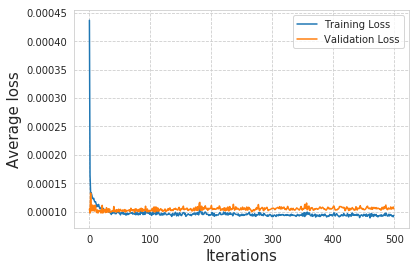

In [49]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.legend()
_ = plt.xlabel('Iterations',fontsize=(15))
_ = plt.ylabel('Average loss',fontsize=(15))